<a href="https://colab.research.google.com/github/GabrielBurack/Machine_learning_course/blob/main/text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

link Kaggle: https://www.kaggle.com/datasets/augustop/portuguese-tweets-for-sentiment-analysis/data



*   Negative Label: 0
*   Positive label: 1




In [ ]:
import spacy
spacy.__version__

'3.7.5'

In [ ]:
!python -m spacy download pt_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 74.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import pandas as pd
import string
import spacy
import random
import seaborn as sns
import numpy as np

# Carregamento da base de dados

In [33]:
base_treinamento = pd.read_csv('Train50.csv', delimiter = ';')
base_treinamento.shape

(50000, 5)

In [35]:
base_treinamento.head()

,id,tweet_text,tweet_date,sentiment,query_used
0,1050785521201541121,@Laranjito76 A pessoa certa para isso seria o ...,Fri Oct 12 16:29:25 +0000 2018,1,:)
1,1050785431955140608,"@behin_d_curtain Para mim, é precisamente o co...",Fri Oct 12 16:29:04 +0000 2018,1,:)
2,1050785401248645120,Vou fazer um video hoje... estou pensando em f...,Fri Oct 12 16:28:56 +0000 2018,1,:)
3,1050785370982547461,"aaaaaaaa amei tanto essas polaroids, nem sei e...",Fri Oct 12 16:28:49 +0000 2018,1,:)
4,1050785368902131713,Valoriza o coração do menininho que vc tem. El...,Fri Oct 12 16:28:49 +0000 2018,1,:)


<Axes: xlabel='sentiment', ylabel='count'>

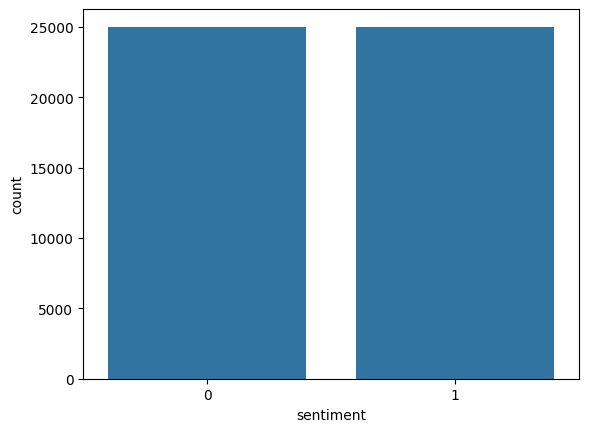

In [34]:
sns.countplot(x = 'sentiment', data = base_treinamento)

In [36]:
base_treinamento.drop(['id','tweet_date', 'query_used'], axis = 1, inplace = True)

<Axes: >

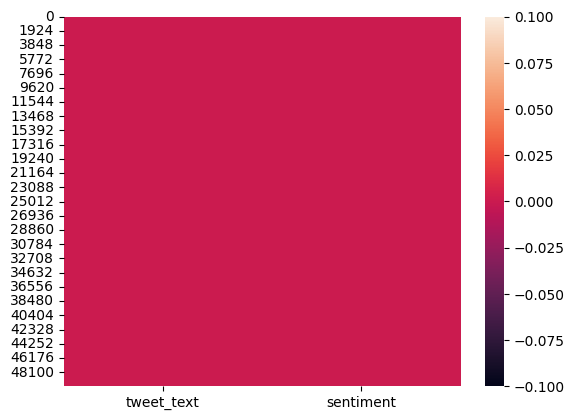

In [41]:
sns.heatmap(pd.isnull(base_treinamento))

base de teste:

In [39]:
base_teste = pd.read_csv('Test.csv', delimiter=';')

In [51]:
base_teste.drop(['id','tweet_date', 'query_used'], axis = 1, inplace = True)

<Axes: >

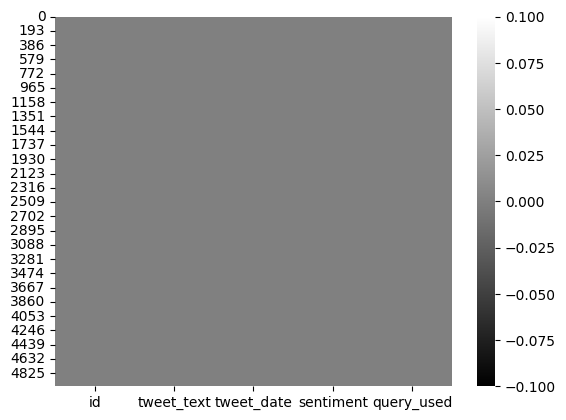

In [43]:
sns.heatmap(pd.isnull(base_teste), cmap='gray')

# Função para pré-processamento dos textos

In [44]:
import re

In [45]:
from spacy.lang.pt.stop_words import STOP_WORDS
stop_words = STOP_WORDS


In [46]:
pln = spacy.load('pt_core_news_sm')

/usr/local/lib/python3.11/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


In [47]:
def preprocessamento(texto):

  texto = texto.lower()
  texto = re.sub(r"@[A-Za-z0-9$-_@.&+]+", ' ', texto)
  texto = re.sub(r"https?://[A-Za-z0-9./]+", ' ', texto)
  texto = re.sub(r" +", ' ', texto)

  lista_emocoes = {':)': 'emocaopositiva',
                   ':d': 'emocaopositiva',
                   ':(': 'emocaonegativa'}
  for emocao in lista_emocoes:
    texto = texto.replace(emocao, lista_emocoes[emocao])

  documento = pln(texto)

  lista = []
  for token in documento:
    lista.append(token.lemma_)

  lista = [palavra for palavra in lista if palavra not in stop_words and palavra not in string.punctuation]
  lista = ' '.join([str(elemento) for elemento in lista if not elemento.isdigit()])

  return lista

# Pré-processamento da base de dados

In [50]:
base_treinamento['tweet_text'] = base_treinamento['tweet_text'].apply(preprocessamento)

In [52]:
base_teste['tweet_text'] = base_teste['tweet_text'].apply(preprocessamento)

In [53]:
base_dados_treinamento_final = []
for text, emotion in zip(base_treinamento['tweet_text'], base_treinamento['sentiment']):
  if emotion == 1:
    dic = ({'positive': True, 'negative': False})
  else:
    dic = ({'positive': False, 'negative': True})

  base_dados_treinamento_final.append([text, dic.copy()])


In [54]:
len(base_dados_treinamento_final)

50000

In [55]:
base_dados_treinamento_final[0]

['  pessoa certo vale azevedo emocaopositivo',
 {'positive': True, 'negative': False}]

# Criação do classificador

In [56]:
from spacy.training import Example

In [57]:
modelo = spacy.blank('pt')
categorias = modelo.add_pipe('textcat')
categorias.add_label('positive')
categorias.add_label('negative')
historico = []

/usr/local/lib/python3.11/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


In [70]:
modelo.begin_training()
for epoca in range(5):
  random.shuffle(base_dados_treinamento_final)
  losses = {}

  for batch in spacy.util.minibatch(base_dados_treinamento_final, 512):
    texts = [modelo(texto) for texto, entities in batch]
    annotations = [{'cats': entities} for texto, entities in batch]
    examples = [Example.from_dict(doc, annotation) for doc, annotation in zip(texts, annotations)]
    modelo.update(examples, losses = losses)
    historico.append(losses)

  if epoca % 5 == 0:
    print(losses)



{'textcat': 1.8102077933843645}


In [71]:
historico_loss = []
for i in historico:
  historico_loss.append(i.get('textcat'))

In [72]:
historico_loss = np.array(historico_loss)
historico_loss


array([1.81553148, 1.81020779, 1.81020779, 1.81020779, 1.81020779,
       1.81020779, 1.81020779, 1.81020779, 1.81020779, 1.81020779,
       1.81020779, 1.81020779, 1.81020779, 1.81020779, 1.81020779,
       1.81020779, 1.81020779, 1.81020779, 1.81020779, 1.81020779,
       1.81020779, 1.81020779, 1.81020779, 1.81020779, 1.81020779,
       1.81020779, 1.81020779, 1.81020779, 1.81020779, 1.81020779,
       1.81020779, 1.81020779, 1.81020779, 1.81020779, 1.81020779,
       1.81020779, 1.81020779, 1.81020779, 1.81020779, 1.81020779,
       1.81020779, 1.81020779, 1.81020779, 1.81020779, 1.81020779,
       1.81020779, 1.81020779, 1.81020779, 1.81020779, 1.81020779,
       1.81020779, 1.81020779, 1.81020779, 1.81020779, 1.81020779,
       1.81020779, 1.81020779, 1.81020779, 1.81020779, 1.81020779,
       1.81020779, 1.81020779, 1.81020779, 1.81020779, 1.81020779,
       1.81020779, 1.81020779, 1.81020779, 1.81020779, 1.81020779,
       1.81020779, 1.81020779, 1.81020779, 1.81020779, 1.81020

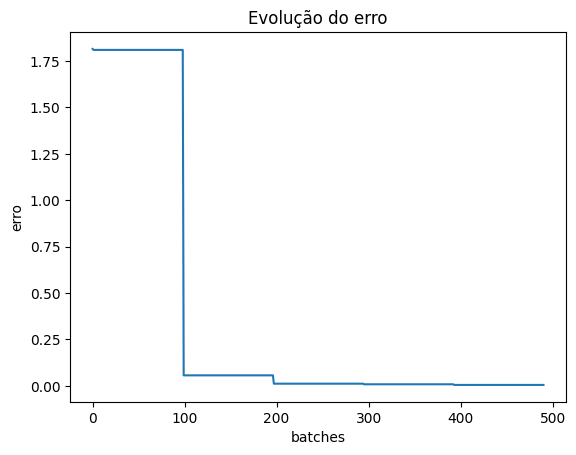

In [73]:
import matplotlib.pyplot as plt

plt.plot(historico_loss)
plt.title('Evolução do erro')
plt.xlabel('batches')
plt.ylabel('erro')
plt.show()

In [74]:
modelo.to_disk('modelo_classificacao_sentimento')

#Testes

In [77]:
modelo_carregado = spacy.load('modelo_classificacao_sentimento')

/usr/local/lib/python3.11/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


##Texto positivo

In [78]:
texto_positivo = 'Eu sou muito contente'
texto_positivo = preprocessamento(texto_positivo)
texto_positivo

'contente'

In [79]:
modelo_carregado(texto_positivo).cats

{'positive': 0.999683141708374, 'negative': 0.0003168737457599491}

##Texto negativo

In [82]:
texto_negativo = 'estou com dor de cabeça'
texto_negativo = preprocessamento(texto_negativo)
texto_negativo

'dor cabeça'

In [83]:
modelo_carregado(texto_negativo).cats


{'positive': 0.3602240979671478, 'negative': 0.6397758722305298}

#Avaliação do modelo

In [84]:
previsoes = []
for texto in base_teste['tweet_text']:
  previsao = modelo_carregado(texto)
  previsoes.append(previsao.cats)

previsoes_final = []
for previsao in previsoes:
  if previsao['positive'] > previsao['negative']:
    previsoes_final.append(1)
  else:
    previsoes_final.append(0)

In [87]:
previsoes_final = np.array(previsoes_final)
previsoes_final

array([1, 1, 1, ..., 0, 0, 0])

In [93]:
respostas_reais = base_teste['sentiment'].values
respostas_reais

array([1, 1, 1, ..., 0, 0, 0])

In [94]:
from sklearn.metrics import accuracy_score
accuracy_score(respostas_rais, previsoes_final)

0.9972

In [95]:
from sklearn.metrics import confusion_matrix
confusion_matrix(respostas_reais, previsoes_final)

array([[2493,    7],
       [   7, 2493]])

<Axes: >

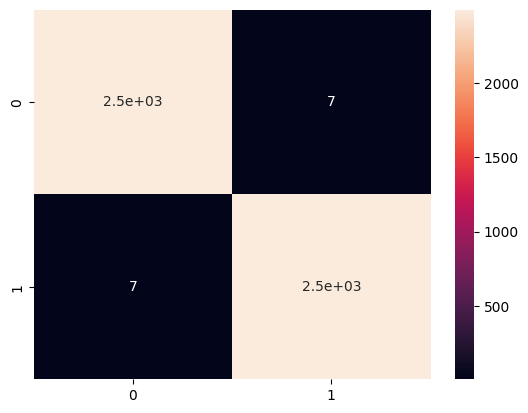

In [96]:
sns.heatmap(confusion_matrix(respostas_reais, previsoes_final), annot=True)